Imports

In [1]:
%load_ext autoreload
%autoreload 2
from translation import BasicBenchmarkTranslator, FJSSPInstancesTranslator, SimpleGAEncoder
from model import Order, ProductionEnvironment, reset_entities, soft_reset
from solver import GASolver, GreedyAgentSolver, PSOSolver
from evaluation import Evaluator, Makespan, IdleTime, TimeDeviation, Profit, UnfulfilledOrders, Tardiness
from visualization import visualize_schedule
import random

<h3>Setup</h3>

In [2]:
order_amount = 10

Data Selection (Only run one of the following blocks)

In [73]:
reset_entities()
fjssp_translator = FJSSPInstancesTranslator()
production_environment = fjssp_translator.translate('6_Fattahi', 2)

In [2]:
reset_entities()
simple_translator = BasicBenchmarkTranslator()
production_environment = simple_translator.translate(3)

Order Generation

In [74]:
def generate_random_orders(amount : int, production_enviornment : ProductionEnvironment) -> list[Order]:
    available_resources = production_enviornment.resources # NOTE: currently works because all resources can be produced
    orders : list[Order] = []
    for i in range(amount):
        resource_id = random.randint(0, len(available_resources)-1)
        resource = production_environment.get_resource(resource_id)
        order = Order(arrival_time=0, delivery_time=1000, latest_acceptable_time=1000, resources=[(resource, 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0) # NOTE: randomize later
        orders.append(order)
    return orders

def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

random.seed(1) # for comparisons

#orders = generate_random_orders(order_amount, production_environment) # NOTE: some of the data is currently the same for every order
orders = generate_one_order_per_recipe(production_environment)

Solver Selection and Configuration (Only run one of the following blocks)

In [75]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders) # NOTE: create duration dictionary
solver = GASolver(values, durations, jobs, production_environment, orders)

start_time_slot = 0
end_time_slot = 1000
population_size = 100
offspring_amount = 200
max_generations = 2000
keep_parents = 0#int(population_size / 6)
crossover = 'two_points' # available options: single_point, two_points, uniform, scattered
selection = 'tournament' # available options: sss (Stead State Selection), rws (Roulette Wheel Selection), sus (Stochastic Universal Selection), rank (Rank Selection), random (Random Selection), tournament (Torunament Selection)
k_tournament = int(population_size/4)
mutation = 'force_feasible' # available options: workstation_only, full_random, random_only_feasible, force_feasible

solver.initialize(earliest_slot=start_time_slot, last_slot=end_time_slot, population_size=population_size, offspring_amount=offspring_amount, max_generations=max_generations, crossover=crossover, selection=selection, mutation=mutation, k_tournament=k_tournament, keep_parents=keep_parents)

c:\Users\huda\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:503: UserWarning:

The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.



In [110]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders) # NOTE: create duration dictionary
solver = GreedyAgentSolver(values, durations, jobs, production_environment, orders)

In [103]:
soft_reset()
start_time_slot = 0
end_time_slot = 1000
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders)
solver = PSOSolver(production_environment=production_environment, encoder=encoder, jobs=jobs, durations=durations, start_time=start_time_slot, end_time=end_time_slot, orders=orders)
use_alternative = True
if not use_alternative:
    solver.initialize(dimensions=len(values), max_iterations=10000, update_weights=False, lower_bounds=[start_time_slot] * len(values), upper_bounds=[end_time_slot] * len(values))
else:
    # TODO: change feasibility and fitness functions NOTE: needs alternative encoder
    lower_bounds = []
    upper_bounds = []
    for i in range(len(values)):
        if i % 2 == 0:
            # bounds for workstation
            lower_bounds.append(0)
            upper_bounds.append(len(production_environment.get_available_workstations_for_task(jobs[int(i/2)])))
        else:
            # bounds for start times
            lower_bounds.append(start_time_slot)
            upper_bounds.append(end_time_slot)
    solver.initialize(dimensions=len(values), max_iterations=10000, update_weights=False, lower_bounds=lower_bounds, upper_bounds=upper_bounds, use_alternative=True)

Objective Selection (Multiple objectives can be added) NOTE: currently only the first added objective is considered during optimization

In [76]:
solver.add_objective(Makespan())

In [77]:
solver.add_objective(IdleTime())

In [78]:
solver.add_objective(TimeDeviation())

In [79]:
solver.add_objective(Tardiness())

In [80]:
solver.add_objective(Profit())

In [81]:
solver.add_objective(UnfulfilledOrders())

<h3>Run the Solver</h3>

In [82]:
solver.run()
print(solver.get_best())
print(solver.get_best_fitness())

Done
[  1 366   0 377   1 368   1 403]
-80.0


<h3>Evaluation</h3>

If the used Solver provides improvement history:

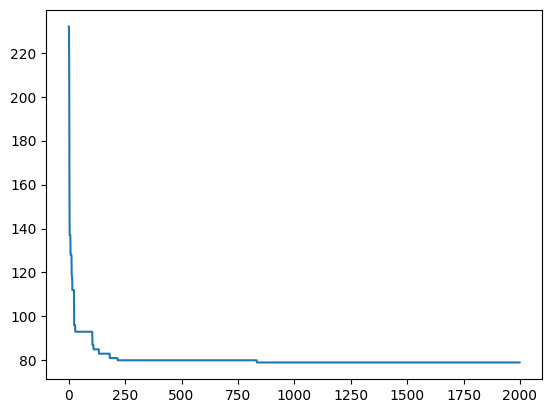

In [83]:
import matplotlib.pyplot as plt
best_history = solver.best_history
generation_average_history = solver.average_history

plt.plot(best_history)
plt.plot(generation_average_history)
plt.show()

In [84]:
schedule = encoder.decode(solver.get_best(), jobs, production_environment, solver=solver)

Visualization

In [85]:
visualize_schedule(schedule, production_environment, orders)

Objective Values

In [86]:
evaluator = Evaluator(production_environment)
evaluator.add_objective(Makespan())
evaluator.add_objective(IdleTime())
evaluator.add_objective(TimeDeviation())
evaluator.add_objective(Tardiness())
evaluator.add_objective(Profit())
evaluator.add_objective(UnfulfilledOrders())
objective_values = evaluator.evaluate(schedule, jobs)
print(f'Solution created with: {solver.name}')
print(objective_values)

Solution created with: GASolver
[80, 745, 1156, 0, 1000.0, 0]


In [87]:
#just testing with python
values = [0, 1, 0, 1, 0, 1, 0, 1]
zeros = values[::2]
ones = values[1::2]
print(zeros)
print(ones)


[0, 0, 0, 0]
[1, 1, 1, 1]
